In [30]:
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


In [17]:
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_colwidth', 20)
pd.set_option('display.max_rows', None) 

In [2]:
# Save merged file
df_stat = pd.read_csv(r"\\rdp.arc.ucl.ac.uk\ritd-ag-project-rd025c-bhall50\ModellingRASopathies RDSS\PTPN11_ClinVar_REVEL.csv")


In [3]:
df_stat

,GRCh38Location,Germline classification,REVEL,AAfrom,AAto,AApos_ClinVar
0,112419113,Likely pathogenic,0.202,M,R,1
1,112419116,Pathogenic/Likely pathogenic,0.213,T,I,2
2,112419121,Conflicting classifications of pathogenicity,0.518,R,G,4
3,112419122,Likely pathogenic,0.393,R,Q,4
4,112446279,Uncertain significance,0.920,W,C,6
...,...,...,...,...,...,...
583,112504745,Uncertain significance,0.182,Q,R,587
584,112504745,Uncertain significance,0.182,Q,R,588
585,112504748,Uncertain significance,0.248,Q,P,588
586,112504748,Uncertain significance,0.248,Q,P,589


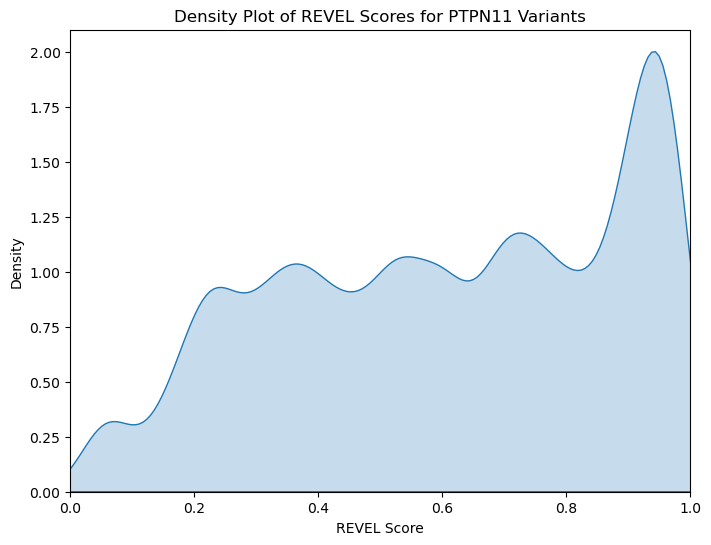

In [4]:
# Plot density
plt.figure(figsize=(8,6))
sns.kdeplot(df_stat['REVEL'], fill=True, bw_adjust=0.5)
plt.title('Density Plot of REVEL Scores for PTPN11 Variants')
plt.xlabel('REVEL Score')
plt.ylabel('Density')
plt.xlim(0,1)  # REVEL scores are between 0 and 1
plt.show()


Optimal REVEL cutoff for PTPN11: 0.708
ROC AUC: 0.876


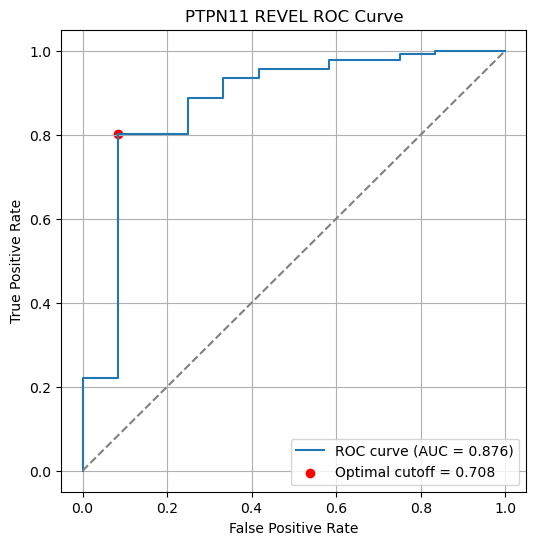

In [27]:
# Map Germline classifications to binary labels
pathogenic_classes = [
    'Pathogenic', 'Likely pathogenic', 'Pathogenic/Likely pathogenic'
]
benign_classes = [
    'Benign', 'Likely benign', 'Benign/Likely benign'
]
uncertain_classes = [
    'Uncertain significance',
    'Uncertain significance; risk factor',
    'Conflicting classifications of pathogenicity',
    'other'
]

prob_map = {cls: 1 for cls in pathogenic_classes}
prob_map.update({cls: 0 for cls in benign_classes})

# Filter to only those rows with defined ClinVar labels
df_stat_ROC = df_stat[df_stat['Germline classification'].isin(prob_map.keys())].copy()
df_stat_ROC['label'] = df_stat_ROC['Germline classification'].map(prob_map)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(df_stat_ROC['label'], df_stat_ROC['REVEL'])
roc_auc = roc_auc_score(df_stat_ROC['label'], df_stat_ROC['REVEL'])

# Optimal cutoff using Youden's J statistic
youden_j = tpr - fpr
optimal_idx = np.argmax(youden_j)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal REVEL cutoff for PTPN11: {optimal_threshold:.3f}")
print(f"ROC AUC: {roc_auc:.3f}")

# Plot ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal cutoff = {optimal_threshold:.3f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('PTPN11 REVEL ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# Classify variants using this cutoff
df_stat_ROC['Predicted'] = np.where(df_stat_ROC['REVEL'] >= optimal_threshold, 'Pathogenic', 'Benign')

# Save the labeled variants
output_file = r"\\rdp.arc.ucl.ac.uk\ritd-ag-project-rd025c-bhall50\ModellingRASopathies RDSS\PTPN11_ClinVar_REVEL_labeled.csv"
df_stat_ROC.to_csv(output_file, index=False)


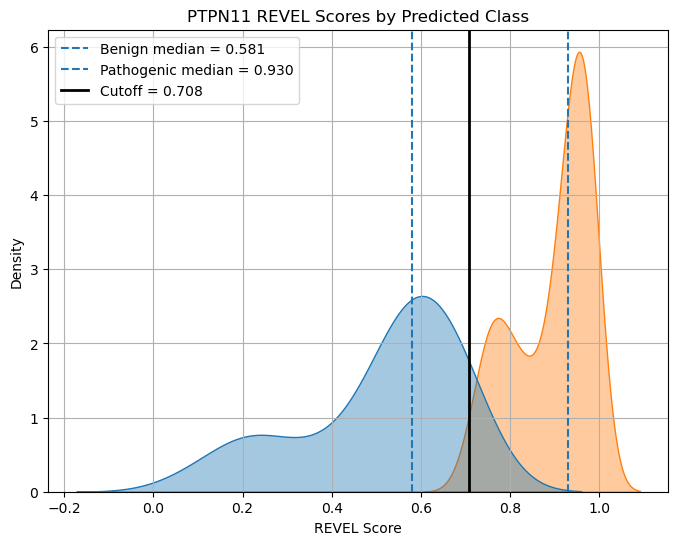

In [28]:
# Compute medians for each class
medians = df_stat_ROC.groupby('Predicted')['REVEL'].median()

# Set REVEL cutoff (from previous ROC analysis)
revel_cutoff = optimal_threshold  

# Plot density
plt.figure(figsize=(8,6))
sns.kdeplot(data=df_stat_ROC, x='REVEL', hue='Predicted', fill=True, common_norm=False, alpha=0.4)

# Add median lines
for label, median_val in medians.items():
    plt.axvline(median_val, linestyle='--', label=f'{label} median = {median_val:.3f}')

# Add cutoff line
plt.axvline(revel_cutoff, color='black', linestyle='-', linewidth=2, label=f'Cutoff = {revel_cutoff:.3f}')

plt.xlabel('REVEL Score')
plt.ylabel('Density')
plt.title('PTPN11 REVEL Scores by Predicted Class')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
# Ensure binary numeric labels: 0 = Benign, 1 = Pathogenic
df_stat_ROC['Predicted_numeric'] = df_stat_ROC['Predicted'].map({'Benign': 0, 'Pathogenic': 1})

# Compute confusion matrix
tn, fp, fn, tp = confusion_matrix(df_stat_ROC['label'], df_stat_ROC['Predicted_numeric']).ravel()

# Compute metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn)  # True Positive Rate
specificity = tn / (tn + fp)  # True Negative Rate

print(f"Accuracy: {accuracy:.3f}")
print(f"Sensitivity (TPR): {sensitivity:.3f}")
print(f"Specificity (TNR): {specificity:.3f}")

Accuracy: 0.810
Sensitivity (TPR): 0.801
Specificity (TNR): 0.917


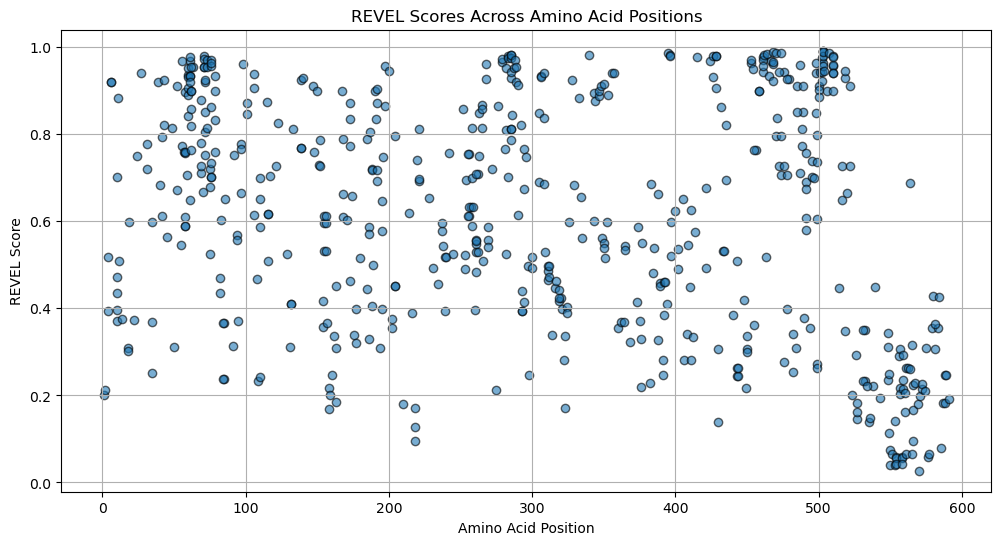

In [11]:
plt.figure(figsize=(12,6))
plt.scatter(df_stat['AApos_ClinVar'], df_stat['REVEL'], alpha=0.6, edgecolor='k')
plt.xlabel('Amino Acid Position')
plt.ylabel('REVEL Score')
plt.title('REVEL Scores Across Amino Acid Positions')
plt.grid(True)
plt.show()

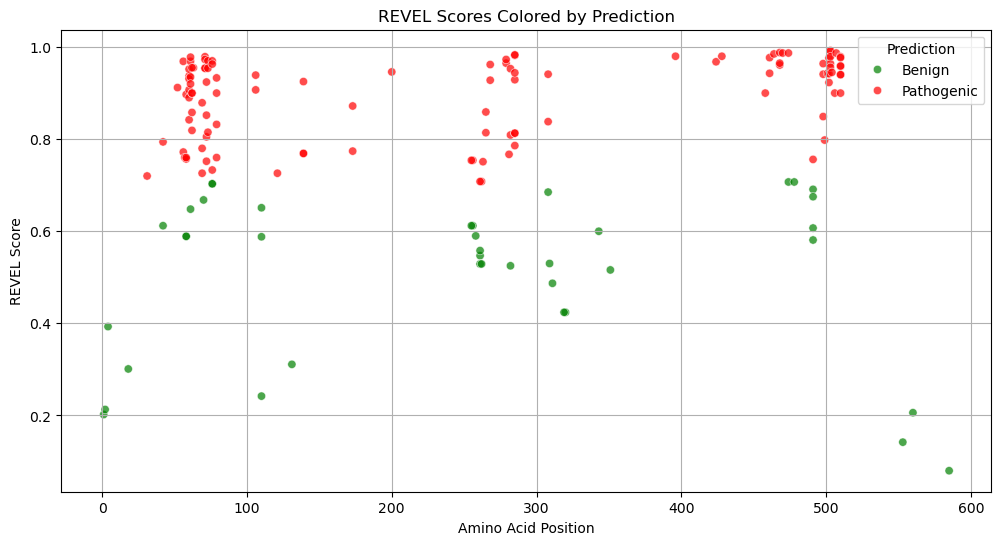

In [16]:
plt.figure(figsize=(12,6))
sns.scatterplot(
    data=df_stat_ROC,
    x='AApos_ClinVar',
    y='REVEL',
    hue='Predicted',  
    palette={'Pathogenic':'red', 'Benign':'green'},
    alpha=0.7
)
plt.xlabel('Amino Acid Position')
plt.ylabel('REVEL Score')
plt.title('REVEL Scores Colored by Prediction')
plt.legend(title='Prediction')
plt.grid(True)
plt.show()

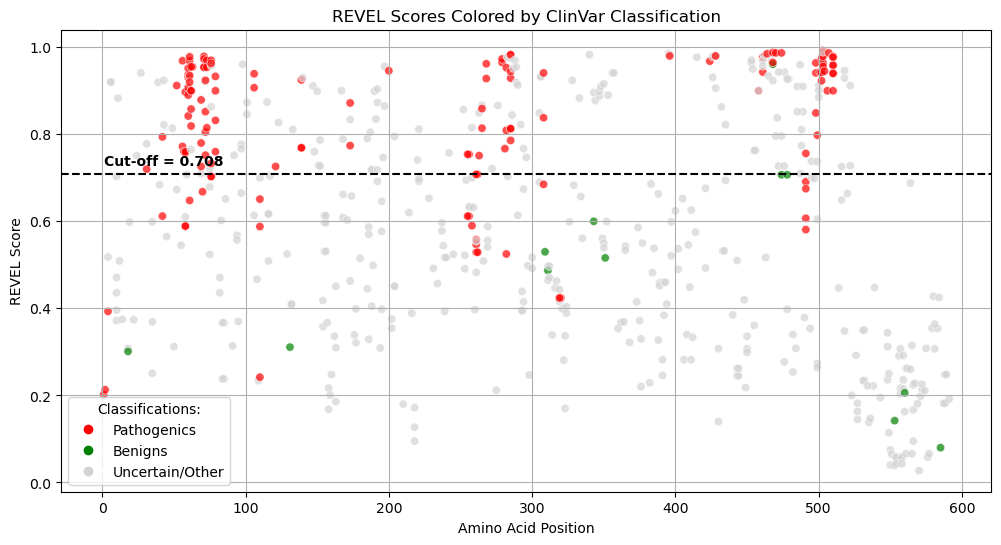

In [33]:
# Build the palette
palette = {}
palette.update({cls: 'red' for cls in pathogenic_classes})
palette.update({cls: 'green' for cls in benign_classes})
palette.update({cls: 'lightgrey' for cls in uncertain_classes})

# Plot
plt.figure(figsize=(12,6))
sns.scatterplot(
    data=df_stat,
    x='AApos_ClinVar',
    y='REVEL',
    hue='Germline classification',
    palette=palette,
    alpha=0.7
)

# Add REVEL cutoff line
plt.axhline(y=revel_cutoff, color='black', linestyle='--', linewidth=1.5)
plt.text(df_stat['AApos_ClinVar'].min(), revel_cutoff + 0.02,
         f'Cut-off = {revel_cutoff}', color='black', fontsize=10, fontweight='bold')


plt.xlabel('Amino Acid Position')
plt.ylabel('REVEL Score')
plt.title('REVEL Scores Colored by ClinVar Classification')
plt.grid(True)

# Legend
custom_legend = [
    Line2D([0], [0], marker='o', color='w', label='Pathogenics',
           markerfacecolor='red', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Benigns',
           markerfacecolor='green', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Uncertain/Other',
           markerfacecolor='lightgrey', markersize=8)
]
plt.legend(handles=custom_legend, title='Classifications:')

plt.show()


In [18]:
df_stat_ROC

,GRCh38Location,Germline classification,REVEL,AAfrom,AAto,AApos_ClinVar,label,Predicted,Predicted_numeric
0,112419113,Likely pathogenic,0.202,M,R,1,1,Benign,0
1,112419116,Pathogenic/Likely pathogenic,0.213,T,I,2,1,Benign,0
3,112419122,Likely pathogenic,0.393,R,Q,4,1,Benign,0
15,112446314,Benign,0.301,N,S,18,0,Benign,0
21,112446353,Likely pathogenic,0.720,A,G,31,1,Pathogenic,1
27,112446385,Likely pathogenic,0.612,T,S,42,1,Benign,0
28,112446385,Pathogenic,0.794,T,A,42,1,Pathogenic,1
35,112450335,Pathogenic,0.912,T,I,52,1,Pathogenic,1
37,112450346,Pathogenic,0.772,I,V,56,1,Pathogenic,1
38,112450347,Likely pathogenic,0.969,I,T,56,1,Pathogenic,1
